In [1]:
import sys
sys.path.append('/kaggle/input/d2l-module')

In [2]:
import os
import math
import collections
import torch
import torchvision
from torch import nn
from datetime import datetime
from d2l import torch as d2l

source_dir='/kaggle/input/dog-breed-identification'
data_dir='/kaggle/working/'

In [3]:
def reorg_dog_data(source_dir,data_dir,valid_ratio):
    """分离训练集和测试集,并将验证集从原始的训练集中拆分出来"""
    labels=d2l.read_csv_labels(os.path.join(source_dir,'labels.csv'))
    n=collections.Counter(labels.values()).most_common()[-1][1] # 训练数据集中样本最少的类别中的样本数
    n_valid_per_label=max(1,math.floor(n*valid_ratio))          # 验证集中每个类别的样本数
    label_count={}
    for train_file in os.listdir(os.path.join(source_dir,'train')):
        label=labels[train_file.split('.')[0]]
        fname=os.path.join(source_dir,'train',train_file)
        d2l.copyfile(fname,os.path.join(data_dir,'train_valid_test','train_valid',label))
        if label not in label_count or label_count[label]<n_valid_per_label:
            d2l.copyfile(fname,os.path.join(data_dir,'train_valid_test','valid',label))
            label_count[label]=label_count.get(label,0)+1
        else:
            d2l.copyfile(fname,os.path.join(data_dir,'train_valid_test','train',label))
    for test_file in os.listdir(os.path.join(source_dir,'test')):
        d2l.copyfile(os.path.join(source_dir,'test',test_file),os.path.join(data_dir,'train_valid_test','test','unknown'))
        
batch_size=128
reorg_dog_data(source_dir,data_dir,valid_ratio=0.1)

In [4]:
transform_train=torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224,scale=(0.08,1.0),ratio=(3.0/4.0,4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

transform_test=torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

train_ds,train_valid_ds=[torchvision.datasets.ImageFolder(os.path.join(data_dir,'train_valid_test',folder),transform=transform_train) for folder in ['train','train_valid']]
valid_ds,test_ds=[torchvision.datasets.ImageFolder(os.path.join(data_dir,'train_valid_test',folder),transform=transform_test) for folder in ['valid','test']]

train_iter,train_valid_iter=[torch.utils.data.DataLoader(dataset,batch_size,shuffle=True,drop_last=True) for dataset in (train_ds,train_valid_ds)]
valid_iter=torch.utils.data.DataLoader(valid_ds,batch_size,shuffle=False,drop_last=True)
test_iter=torch.utils.data.DataLoader(test_ds,batch_size,shuffle=False,drop_last=False)

In [5]:
def get_net(devices):
    finetune_net=nn.Sequential()
    finetune_net.features=torchvision.models.resnet34(pretrained=True)
    # 定义一个新的输出网络,共有120个输出类别
    finetune_net.output_new=nn.Sequential(nn.Linear(1000,256),nn.ReLU(),nn.Linear(256,120))
    nn.init.kaiming_uniform_(finetune_net.output_new[0].weight)
    nn.init.kaiming_uniform_(finetune_net.output_new[2].weight)
    finetune_net=finetune_net.to(devices[0])
    for params in finetune_net.features.parameters():
        params.requires_grad=False  # 冻结参数
    return finetune_net

loss=nn.CrossEntropyLoss(reduction='none')

def train(net,train_iter,valid_iter,num_epochs,lr,wd,devices):
    net=nn.DataParallel(net,device_ids=devices).to(devices[0])
    trainer=torch.optim.SGD((param for param in net.parameters() if param.requires_grad),lr=lr,momentum=0.9,weight_decay=wd)
    scheduler=torch.optim.lr_scheduler.MultiStepLR(trainer,[140,190],0.1)
    timer,animator=d2l.Timer(),d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0,1],legend=['train loss','train acc','valid acc'] if valid_iter is not None else ['train loss','train acc'])
    for epoch in range(num_epochs):
        net.train()
        metric=d2l.Accumulator(3)
        for i,(features,labels) in enumerate(train_iter):
            timer.start()
            l,acc=d2l.train_batch_ch13(net,features,labels,loss,trainer,devices)
            metric.add(l,acc,labels.shape[0])
            timer.stop()
        animator.add(epoch+1,(metric[0]/metric[2],metric[1]/metric[2],None))
        if valid_iter is not None:
            valid_acc=d2l.evaluate_accuracy_gpu(net,valid_iter)
            animator.add(epoch+1,(None,None,valid_acc))
        scheduler.step()
    print(f'train loss {metric[0]/metric[2]:.3f}, train acc {metric[1]/metric[2]:.3f}'+(f', valid acc {valid_acc:.3f}' if valid_iter is not None else '')+f'\n{metric[2]*num_epochs/timer.sum():.1f} examples/sec on {str(devices)}')

train loss 0.830, train acc 0.795, valid acc 0.838
952.0 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


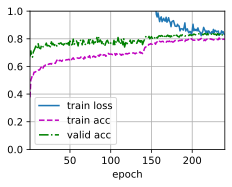

In [9]:
devices,num_epochs,lr,wd=d2l.try_all_gpus(),240,5e-4,5e-4
net=get_net(devices)
train(net,train_iter,valid_iter,num_epochs,lr,wd,devices)
torch.save(net.state_dict(),os.path.join(data_dir,'resnet34-dog-breed-'+str(num_epochs)+'epochs-'+datetime.now().isoformat()+'.pth'))

In [10]:
#net=get_net(devices)
#train(net,train_valid_iter,None,num_epochs,lr,wd,devices)
#torch.save(net.state_dict(),os.path.join(data_dir,'resnet34-dog-breed-'+str(num_epochs)+'epochs-'+datetime.now().isoformat().+'pth'))
preds=[]
net.eval()
for data,label in test_iter:
    output=torch.nn.functional.softmax(net(data.to(devices[0])),dim=1)
    preds.extend(output.cpu().detach().numpy())
ids=sorted(os.listdir(os.path.join(data_dir,'train_valid_test','test','unknown')))
with open(os.path.join(data_dir,'submission.csv'),'w') as f:
    f.write('id,'+','.join(train_valid_ds.classes)+'\n')
    for i,output in zip(ids,preds):
        f.write(i.split('.')[0]+','+','.join([str(num) for num in output])+'\n')